# **Google colab**

---


Google dispone de capacidad de computo en la nube para sus usuarios de gmail en las siguientes secciones al lanzar el código se activaran 12GB de RAM y aprox 100 Gb de almacenamiento para correr codigo en bash o python.

# **Preparación de librería y secuenciación**

---



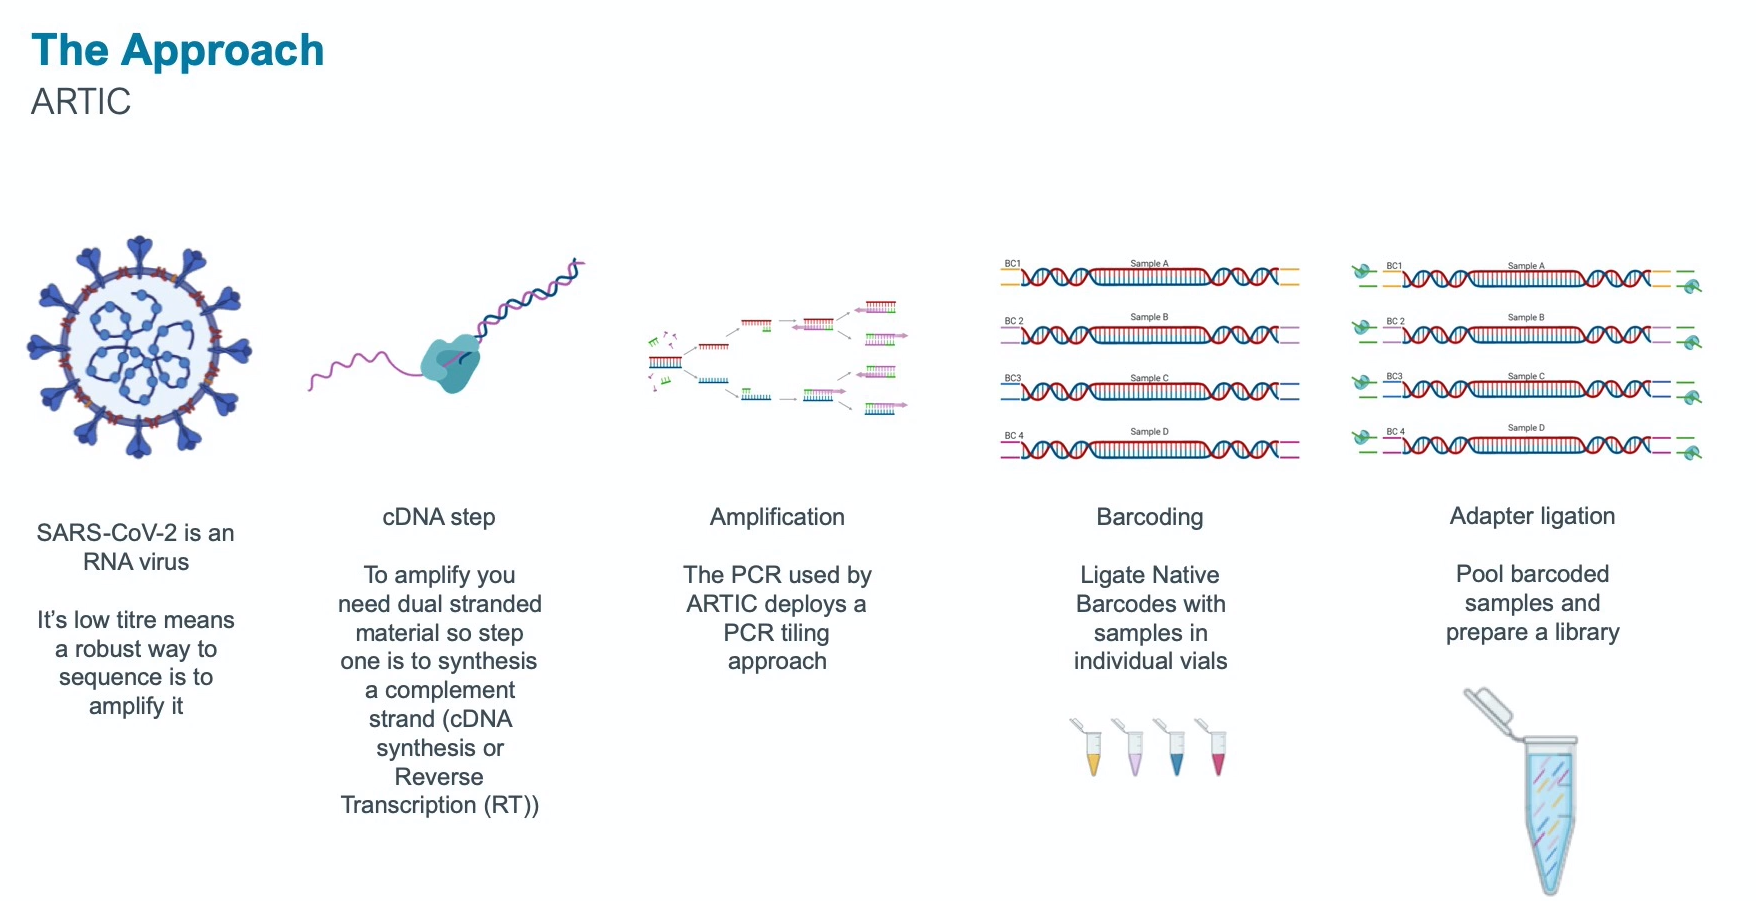

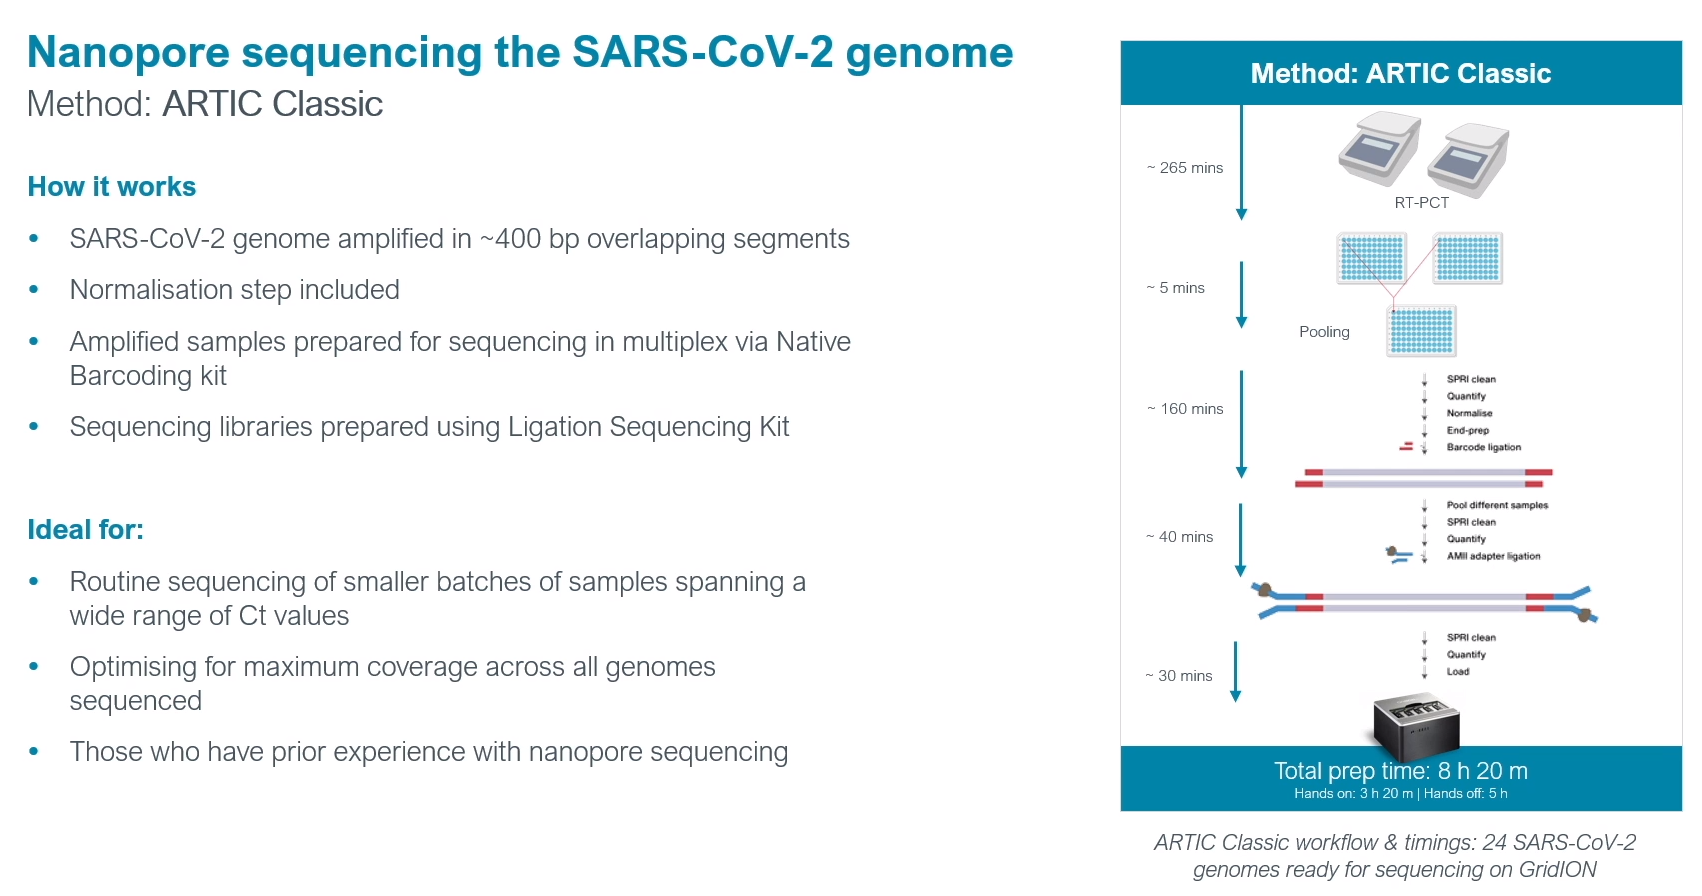

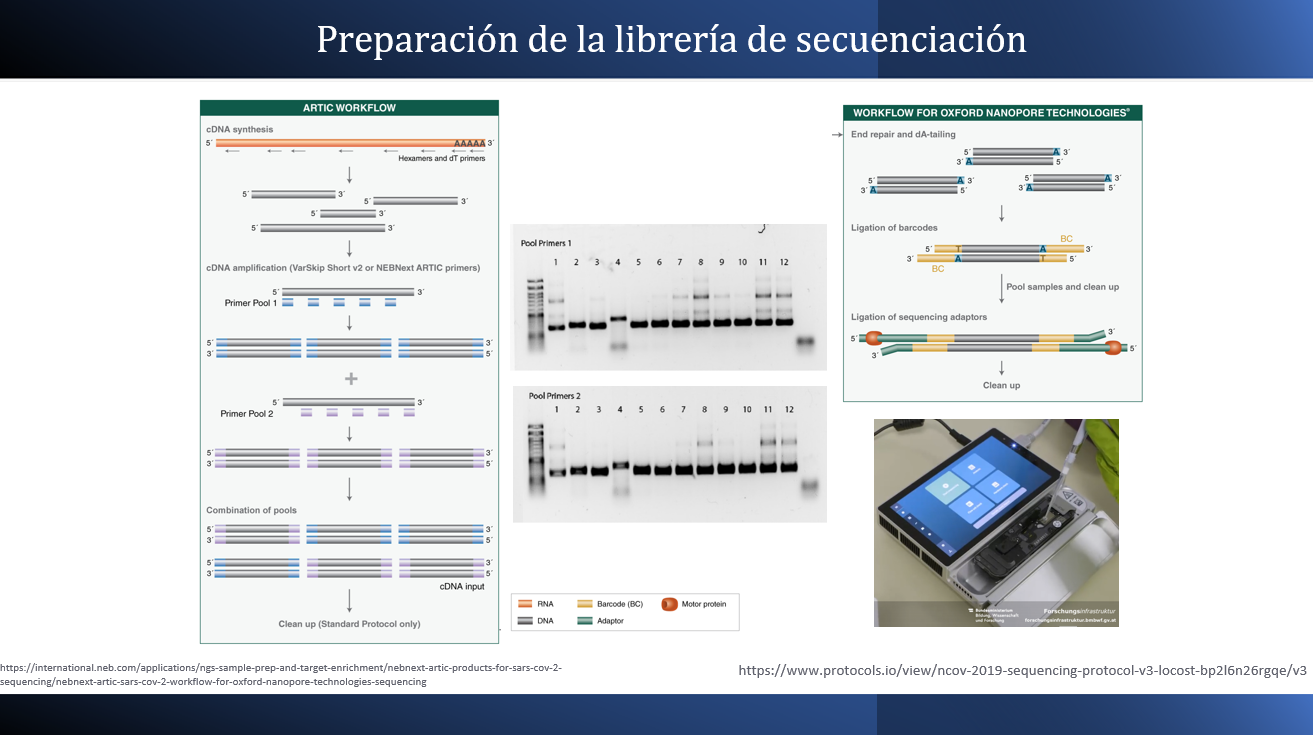

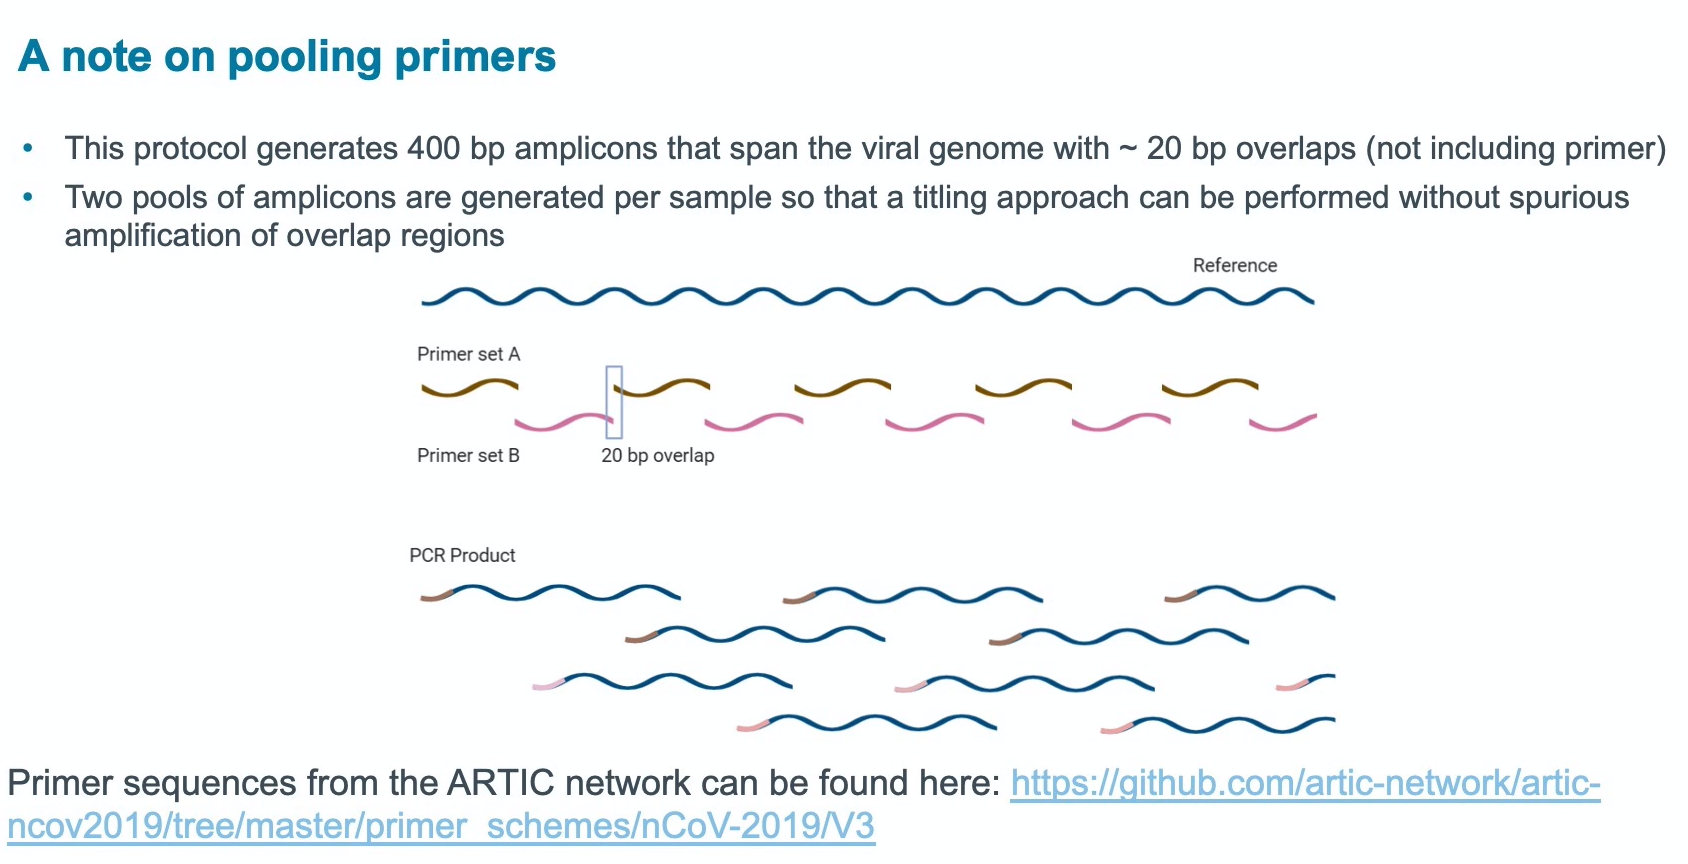

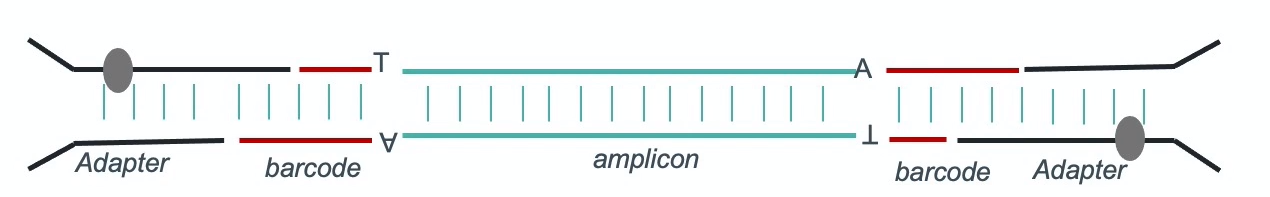

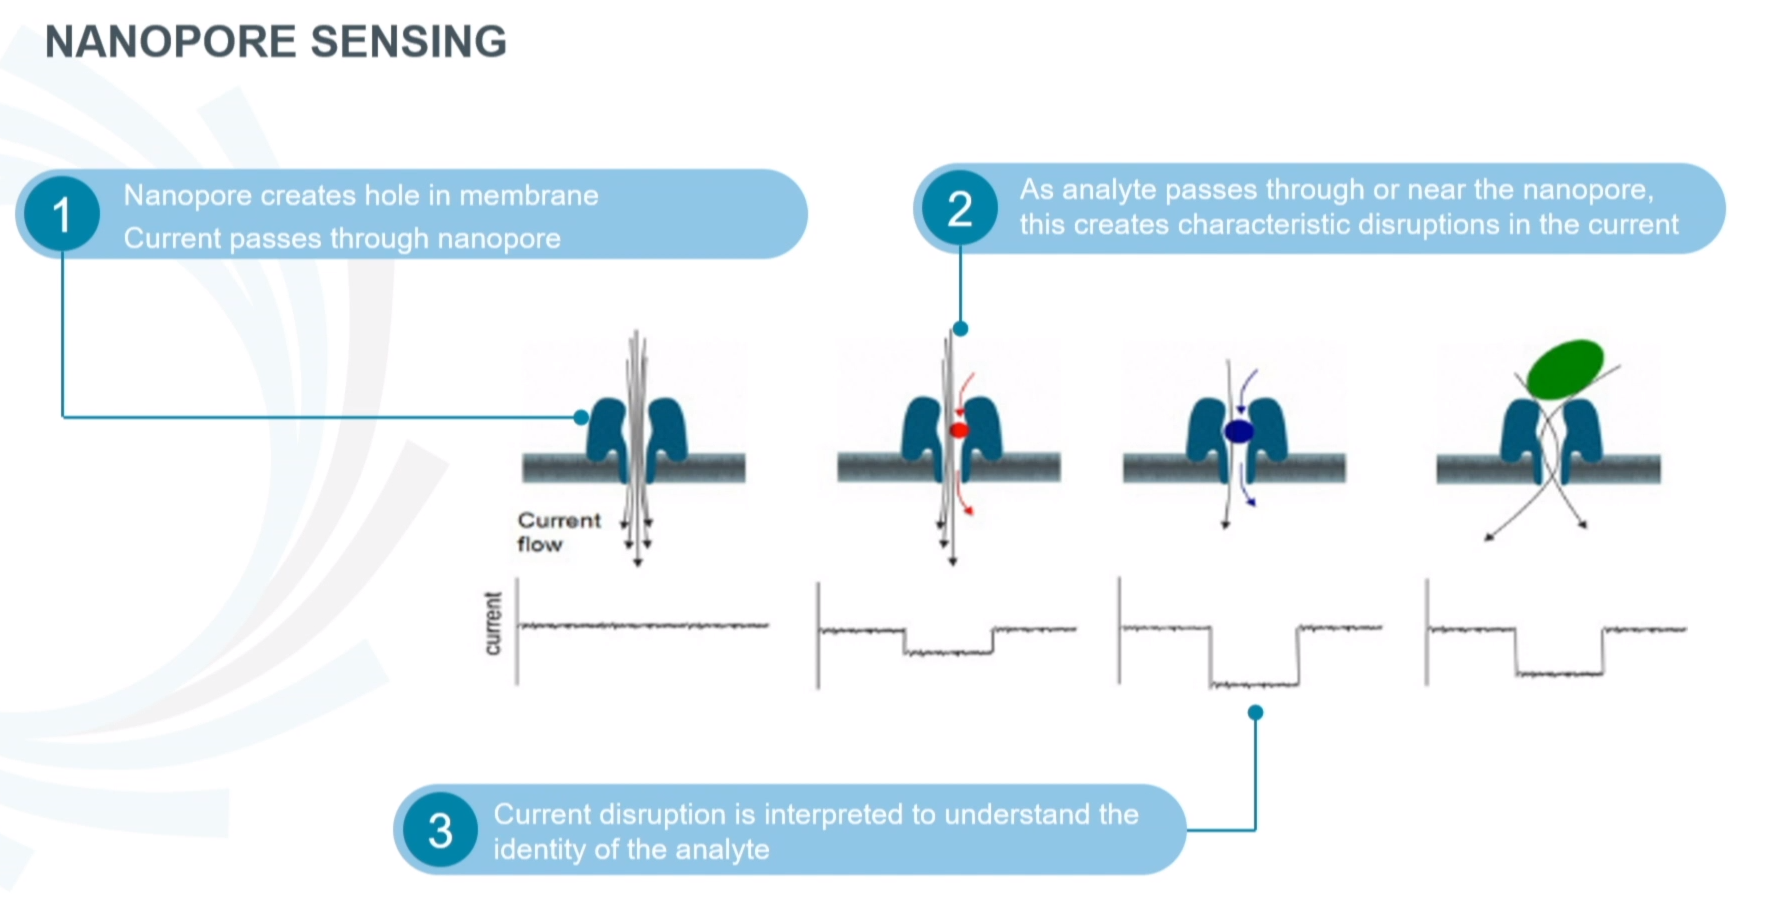

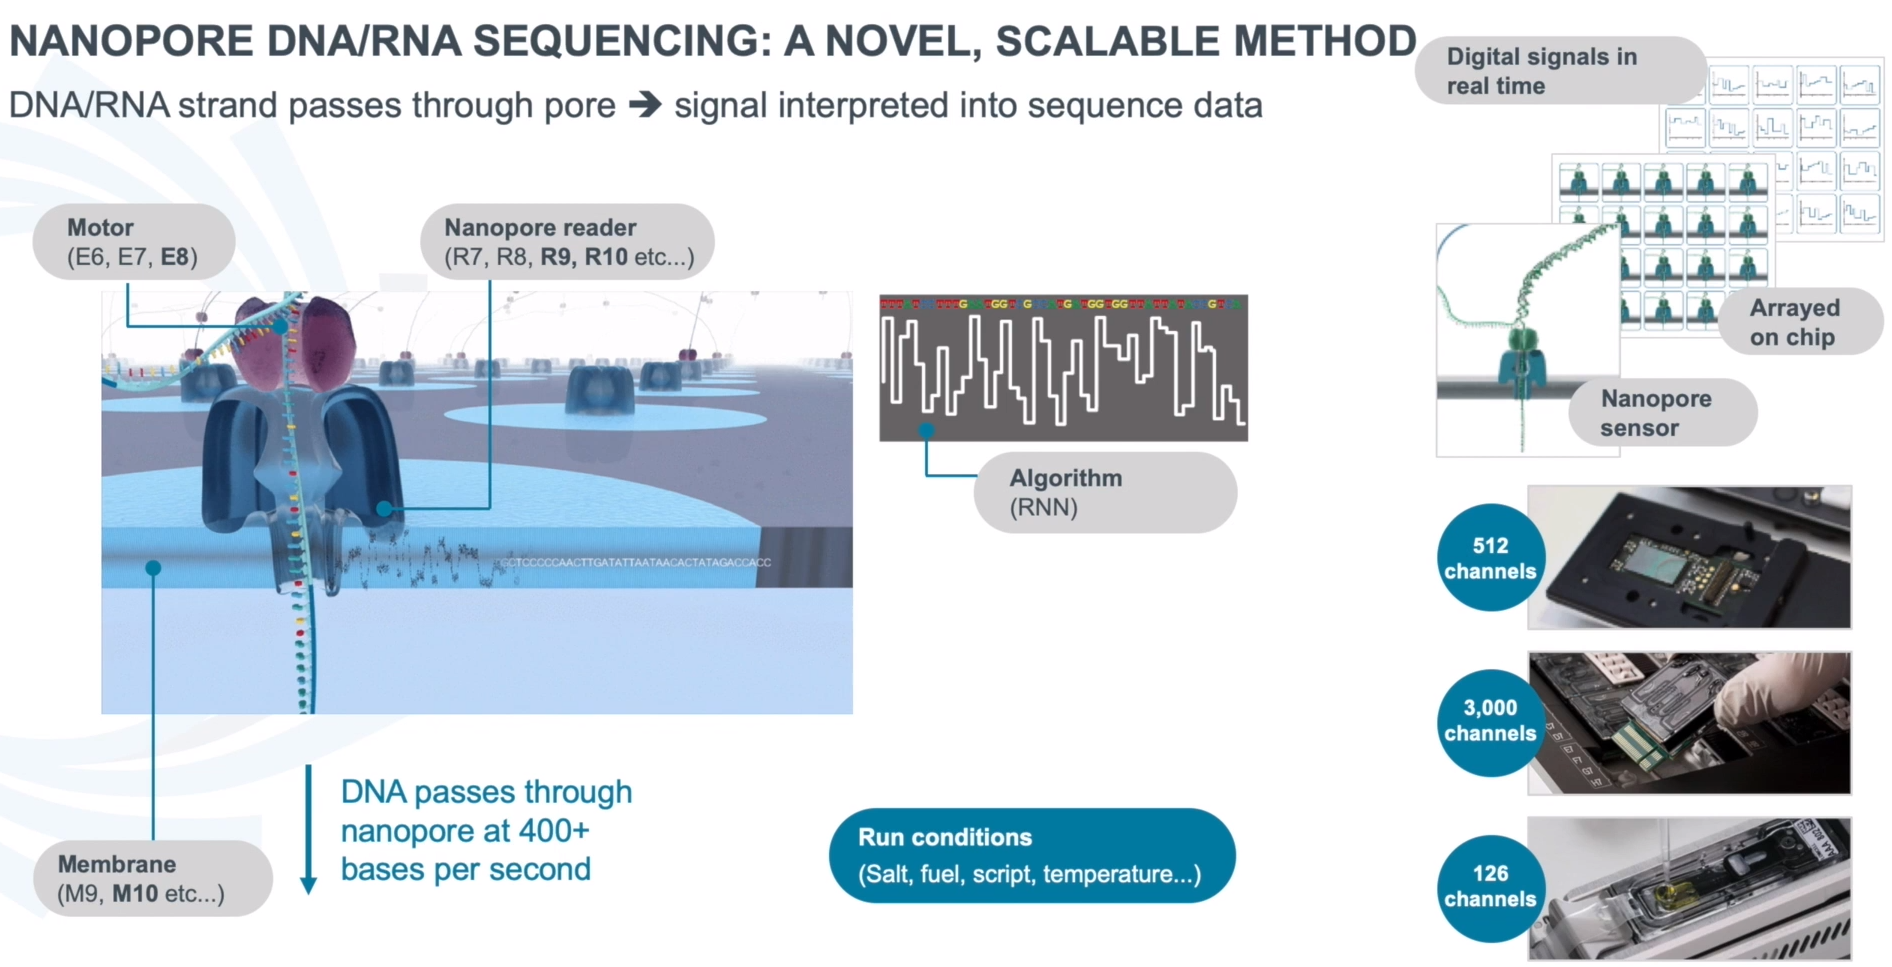

# **Análisis de genoma SarsCoV2** 

---
Links de interés:
* https://www.ncbi.nlm.nih.gov/sars-cov-2/
* https://github.com/CDCgov/SARS-CoV-2_Sequencing

# **Pasos:**


1. Instalación de los programas o paquetes necesarios para
analizar un archivo de secuenciación obtenido por ONT. **Crearemos un ambiente de trabajo con conda.**
2. Inspección del archivo **fast5** **fastq** y **fasta**
3. Control de calidad valor **phredQ** **FastQC** y trimming de la secuencia **Nanofilt**.
4. **Alineamiento** **minimap2** de las lecturas al genoma de referencia
5. Entendiendo el Alineamiento verificar **covertura y profundidad**
6. Predicción de **ORFs y blastp**
7. complementar con archivo de **anotación NCBI**
8. Análisis de variantes **VCF**
9. Filogenia Usher; **variante** **clado** de la muestra




# **Instalación de Conda**  

Conda permite crear ambientes de trabajo dentro de un mismo computador, en los cuales podemos instalar versiones especificas de ciertos paquetes ("programas").
Ejemplo:
1.  
Podemos crear un ambiente que usaremos para el alineamiento de secuencias largas (conda env create large_seq), para eso instalariamos python v3.8 y minimap2 v2.3. 
Y en la misma computadora, queremos hacer un análisis de secuencias cortas (conda env create **short_seq**) necesitaremos instalar python v3.6 y bwa v2.0. 
2. Así podemos instalar un mismo programa pero distintas versiones en una misma computadora, evitando conflictos de versiones y entre paquetes. Muchas veces los programas requiren una versión X de python y otros una versión más actualizada.
3. Así hacemos de los pipelines procesos más reproducibles.

In [ ]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh                 #Descargamos el archivo para la instalación de conda
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh                                                  #Otorgamos la caracteristica ejecutable +x
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local                                #Ejecutamos el archivo para que ocurra la instalación # aprox 3 min

# Instalar los softwares necesarios 

La instalación de programas en conda es mucho más fácil y sigue una forma del tipo: conda install -c (canal del repositorio) nombre_del_software_a_instalar es muy facil de buscar en google

In [ ]:
! conda install -y -c "conda-forge/label/gcc7" biopython                                       #aprox 1 min  #biopython es una libreria de python con scripts bioinformaticos 

# Descargar los archivos para el análisis

En este ejemplo trabajaremos con datos de secuenciación obtenidos a partir de un equipo MinION mk1c usando una celda de flujo r10.3 

In [ ]:
! wget https://github.com/Jpablo334/Workshop_virus/raw/master/00_barcode09.fast5.gz             #Archivo lecturas fast5
! wget https://github.com/Jpablo334/Workshop_virus/raw/master/02_barcode09.fastq                #Archivo lecturas fastq 
! wget https://github.com/Jpablo334/Workshop_virus/raw/master/03_fastq_to_fasta.py              #Script para transformar fastq a fasta # 10 sec
! wget https://github.com/Jpablo334/Workshop_virus/raw/master/barcode_sequences_NBD196_12.txt   #archivo barcodes
! wget https://github.com/Jpablo334/Workshop_virus/raw/master/05_nCoV_2019.reference.fasta #Descargar el genoma de referencia a utilizar 

Inspección de archivos FAST5

Los datos de señales crudas en la secuenciación nanopore se almacenan en formato HDF5. **HDF o "Herarchical data format"** es similar a los archivos json. Estos archivos HDF incluyen **grupos, atributos y dataset**. Un grupo puede contener grupos o datsets y pueden contener atributos. Un dataset contiene un arreglo de datapoints. La forma en que se almacena la información en HDF5 permite tener **acceso** a grupos individuales dentro del dataset de forma **eficiente y rápida**. Se deben ocupar herramientas para interpretarlos. Usaremos **h5dump y h5ls**. H5dump permite examinar el contenido del archivo en formato ASCII. h5ls permite enlistar características especificas contenidos en el HDF5 

https://denbi-nanopore-training-course.readthedocs.io/en/latest/basecalling/inspect_h5.html

In [ ]:
! gunzip 00_barcode09.fast5.gz                      # Descomprir el archivo fast5

In [ ]:
! head 00_barcode09.fast5                           # inspección del archivo fast5

In [ ]:
! conda install -y -c conda-forge hdf5              # 2 min

In [ ]:
! h5dump 00_barcode09.fast5  > 01_barcode09.fast5   #inspección directa del archivo fast5

In [ ]:
! head -n 50 01_barcode09.fast5

In [ ]:
! h5ls 00_barcode09.fast5                           #lista todos los reads obtenidos

In [ ]:
! h5ls 00_barcode09.fast5  | wc -l

In [ ]:
! h5ls 00_barcode09.fast5/read_fb23e592-9386-4460-97f6-d15985f1dbc8 #revisar el contenido de un read entrega el contenido de un subdirectorio

In [ ]:
! h5ls 00_barcode09.fast5/read_fb23e592-9386-4460-97f6-d15985f1dbc8/Raw # queremos obtener la data cruda

In [ ]:
! h5ls -e -d 00_barcode09.fast5/read_fb23e592-9386-4460-97f6-d15985f1dbc8/Raw/Signal Dataset  # queremos obtener la data cruda
# saldrá un error pero el output se presenta en la figura de abajo

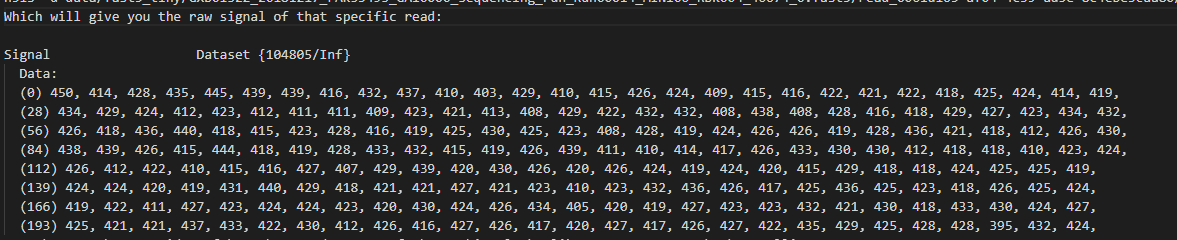

Omitiremos el bassecalling realizado con guppy para ahorrar tiempo, y veremos el resultado añadido al archivo FAST5

In [ ]:
! h5ls -d 00_barcode09.fast5/read_fb23e592-9386-4460-97f6-d15985f1dbc8/Analyses/Basecall_1D_000/BaseCalled_template

Inspeccionamos el archivo FASTQ que descargamos

---



In [ ]:
!head 02_barcode09.fastq

Ejecutar script para transformar el archivo fastq a fasta 

In [ ]:
! python3 03_fastq_to_fasta.py                                                              #Ejecuta script para transformar fastq a fasta

Inspeccionamos el archivo FASTA

---



In [ ]:
!head 04_barcode09.fasta

Comandos rápidos para obtener el numero de secuencias fasta contenidas en el archivo

In [ ]:
! grep ">" 04_barcode09.fasta | wc -l                                                       # Obtener numero de secuencias o headers en el archivo fasta

# **Control de calidad de la secuenciación**

---





*   Valor PhredQ
*   Largo de las secuencias




In [ ]:
! conda install -y -c "bioconda/label/cf201901" nanostat #32 sec

In [ ]:
! NanoStat --fastq 02_barcode09.fastq > nanostat_barcode_09.txt # 3 sec

Inespeccionamos el archivo y verificamos si las lecturas están filtradas por valor phredQ

In [ ]:
! cat nanostat_barcode_09.txt

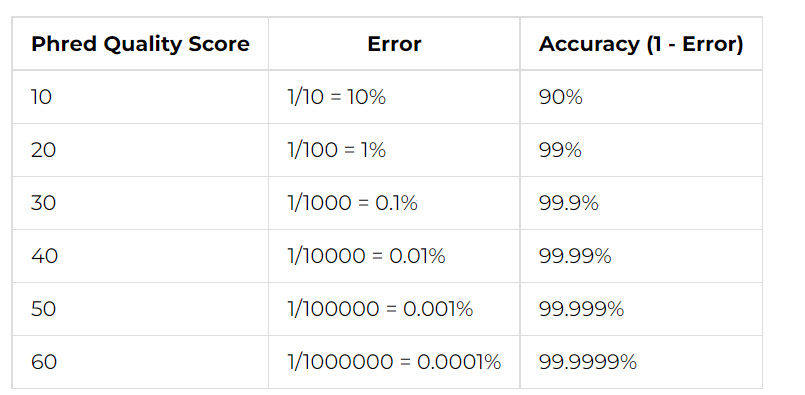

EJ: Filtro por valor phredQ>10 (precisión 90%)

Evaluar el valor PhredQ por base

In [ ]:
! conda install -y -c bioconda fastqc # 3 min

In [ ]:
! mkdir fastqc

In [ ]:
! fastqc -a barcode_sequences_NBD196_12.txt -o fastqc 02_barcode09.fastq

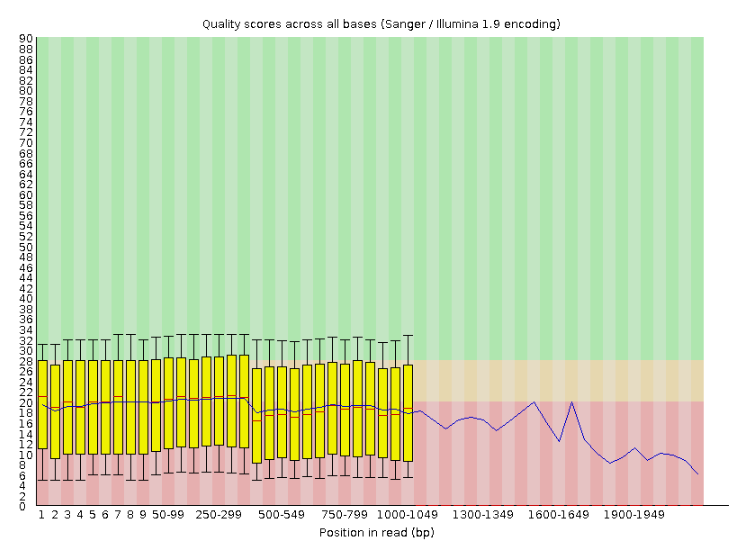

Para hacer trimming de lecturas de ONT se sugiere el uso de la herramienta NanoFilt

In [ ]:
! conda install -y -c "bioconda/label/cf201901" nanofilt # 30 sec

* NanoFilt no tiene las opciones para entregar un archivo como input o un archivo como salida por lo que usaremos los operadores "<" o ">" para dirigir la entrada y salida, respectivamente.

https://labs.epi2me.io/quality-scores/

In [ ]:
! NanoFilt -h

-q quality phred cutoff (7)
--headcropt corta las primeras 3 bases
--maxlength eliminamos las lecturas con un largo mayor a 400 bp

In [ ]:
! NanoFilt --headcrop 3 < 02_barcode09.fastq > 06_barcode09_filt.fastq # 7 sec

Ahora revisamos como quedaron los archivos

In [ ]:
! fastqc -o fastqc 06_barcode09_filt.fastq

In [ ]:
! NanoStat --fastq 06_barcode09_filt.fastq > nanostat_barcode_09_filt.txt

In [ ]:
! cat nanostat_barcode_09_filt.txt

Ya revisamos nuestros archivos de secuencias ahora, continuaremos con el alineamiento

# **Ensamblaje de genoma**

---

Ejemplos de ensambladores:Raven, SpAdes, Wengan, Velvet, entre otros.

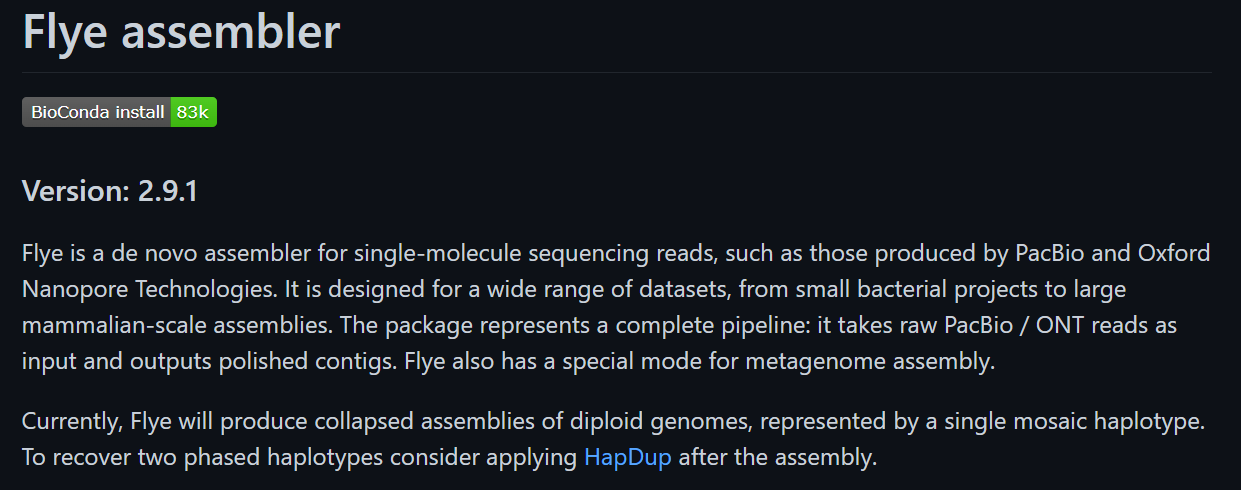

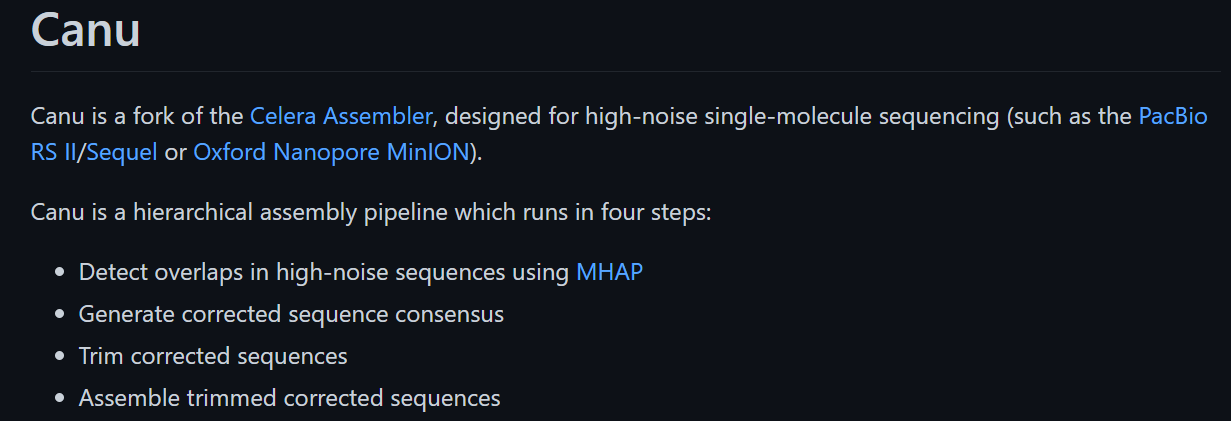

In [ ]:
! conda install -y -c "bioconda/label/cf201901" canu #51 sec

In [ ]:
! mkdir canu_output
! mkdir canu_output_filt

In [ ]:
! canu -h


In [ ]:
! canu -assemble genomeSize=30k -nanopore-raw 02_barcode09.fastq -p bc09_assem -d canu_output useGrid=false minReadLength=200 minOverlapLength=10 # 5 min 40 sec

In [ ]:
! canu -assemble genomeSize=30k -nanopore-corrected 06_barcode09_filt.fastq -p bc09_assem_filt -d canu_output_filt useGrid=false minReadLength=200 minOverlapLength=20 # 5 min 40 sec

In [ ]:
! mkdir -pquast_input
! cp /content/canu_output/bc09_assem.contigs.fasta /content/quast_input/bc09_assem.contigs.fasta
! cp /content/canu_output_filt/bc09_assem_filt.contigs.fasta /content/quast_input/bc09_assem.contigs_filt.fasta

Ahora realizamos una comparación de ensamblajes con las lecturas sin filtrar y las lecturas filtradas con QUAST

In [ ]:
! conda install -y -c bioconda quast #4 min

In [ ]:
! quast -o quast_result -r 05_nCoV_2019.reference.fasta /content/quast_input/*.fasta

# **Alineamiento al genoma de referencia**

---



Previamente ya descargamos el genoma de referencia
necesitamos herramientas adicionales: 
* Instalar minimap2 
https://github.com/lh3/minimap2
o instalar minimap2 con conda

In [ ]:
! conda install -y -c "bioconda/label/cf201901" minimap2 #30 sec
! minimap2

In [ ]:
! conda install -y -c "bioconda/label/cf201901" samtools #40 sec
! samtools

Realizamos el alineamiento de las lecturas y se les adiciona un índice de coordenadas respecto al genoma de referencia utilizado:
-a output format SAM

In [ ]:
! minimap2 -ax map-ont -t 4 05_nCoV_2019.reference.fasta 02_barcode09.fastq  | samtools view -bS -F 4 - | samtools sort -o barcode09.sorted.bam

In [ ]:
! minimap2 -ax map-ont -t 4 05_nCoV_2019.reference.fasta 06_barcode09_filt.fastq  | samtools view -bS -F 4 - | samtools sort -o barcode09_filt.sorted.bam

In [ ]:
! samtools index barcode09.sorted.bam
! samtools index barcode09_filt.sorted.bam

Ahora podemos: Visualizar el alineamiento descargando el archivo bam y bam.bai en el software IGV

Descargar IGV e instalar version windows java included

https://software.broadinstitute.org/software/igv/download


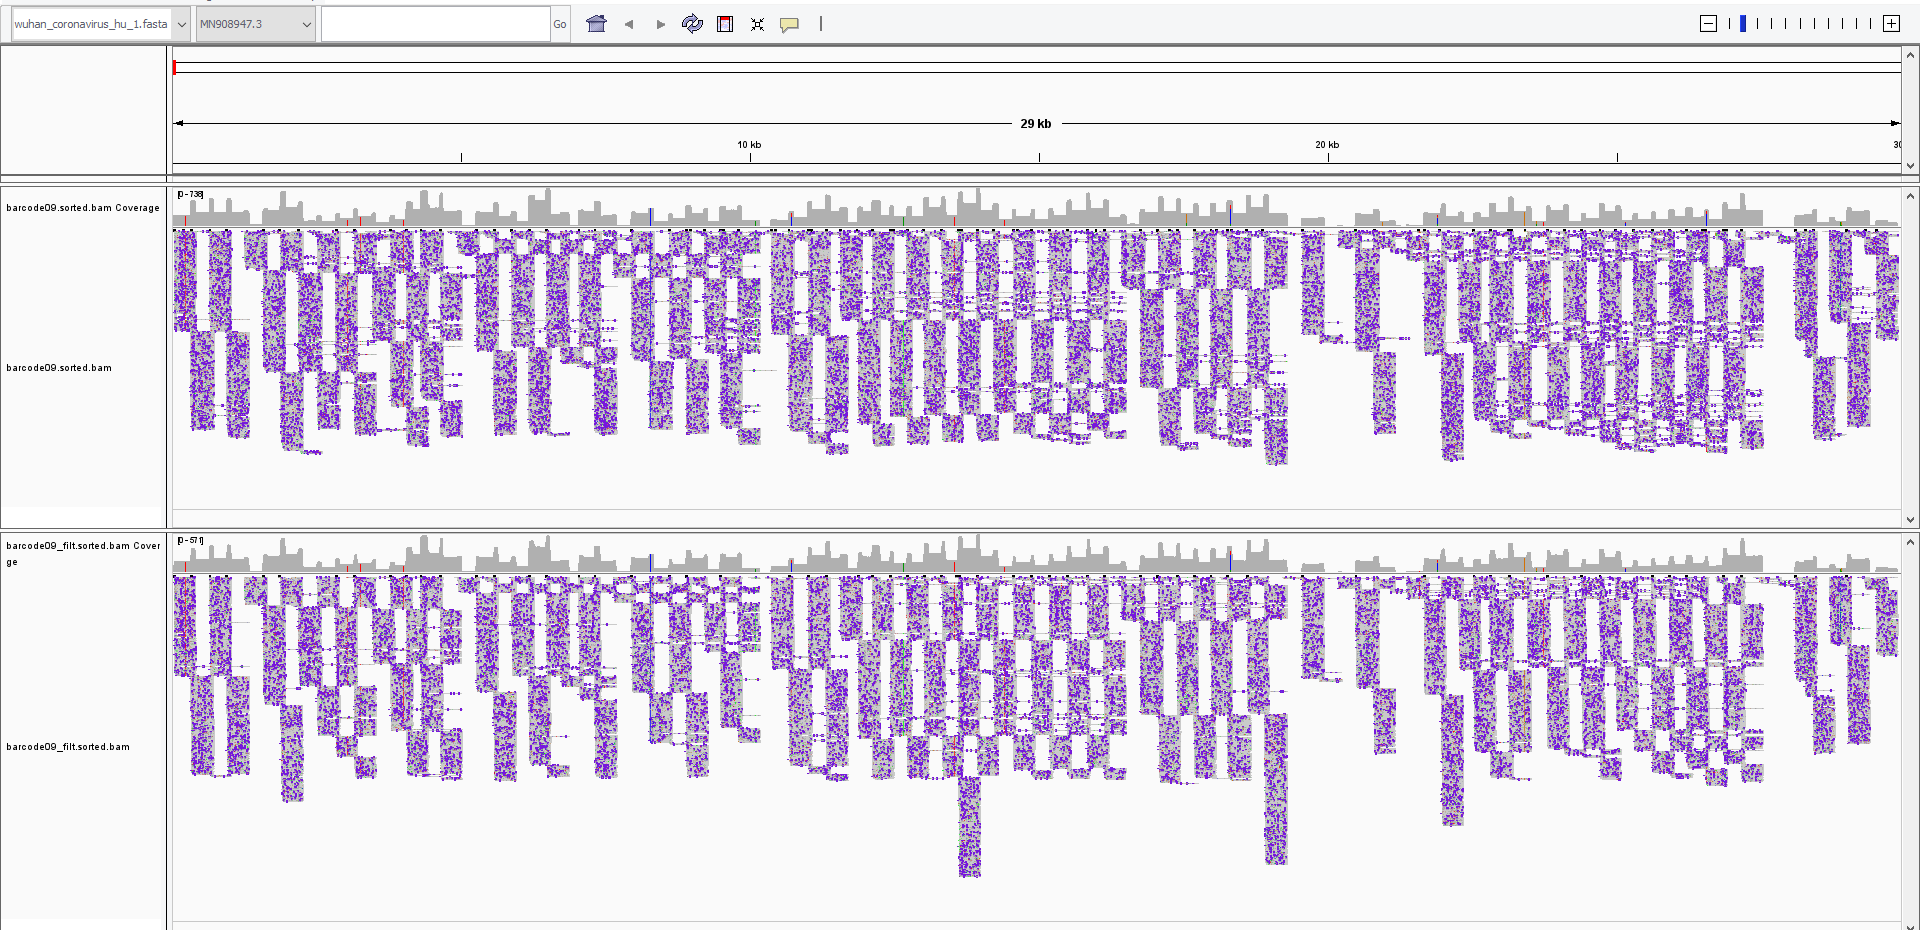

Obtendremos algunas características del alineamiento

In [ ]:
! samtools depth barcode09.sorted.bam > barcode09_per_base_depth.txt #numero de veces que cada base ha sido secuenciada

In [ ]:
! head barcode09_per_base_depth.txt

Una herramienta alternativa es Bedtools

In [ ]:
! conda install -y -c "bioconda/label/cf201901" bedtools
! bedtools

In [ ]:
! bedtools genomecov -ibam  barcode09.sorted.bam -d > barcode09.coverage_per_base_hist.txt     # Número de veces que cada base ha sido secuenciada

In [ ]:
! head -n 50 barcode09.coverage_per_base_hist.txt

Profundiad por base

In [ ]:
import pandas as pd
import numpy as np
data=pd.read_csv('barcode09.coverage_per_base_hist.txt', sep='\t', header=None, names=["Column1", "Column2","Column3"])
#print(data)
import matplotlib.pyplot as plt
x = data['Column2']
y1 = data['Column3']
plt.plot(x,y1, label='barcode09')
plt.xlabel('base_position')
plt.ylabel('freq')
plt.title('base_depth')
plt.legend()
plt.show()

# **Alineamiento, secuencia consenso y llamado de variantes con Medaka**

---



**instalar** ultima version de medaka con los modelos para r10
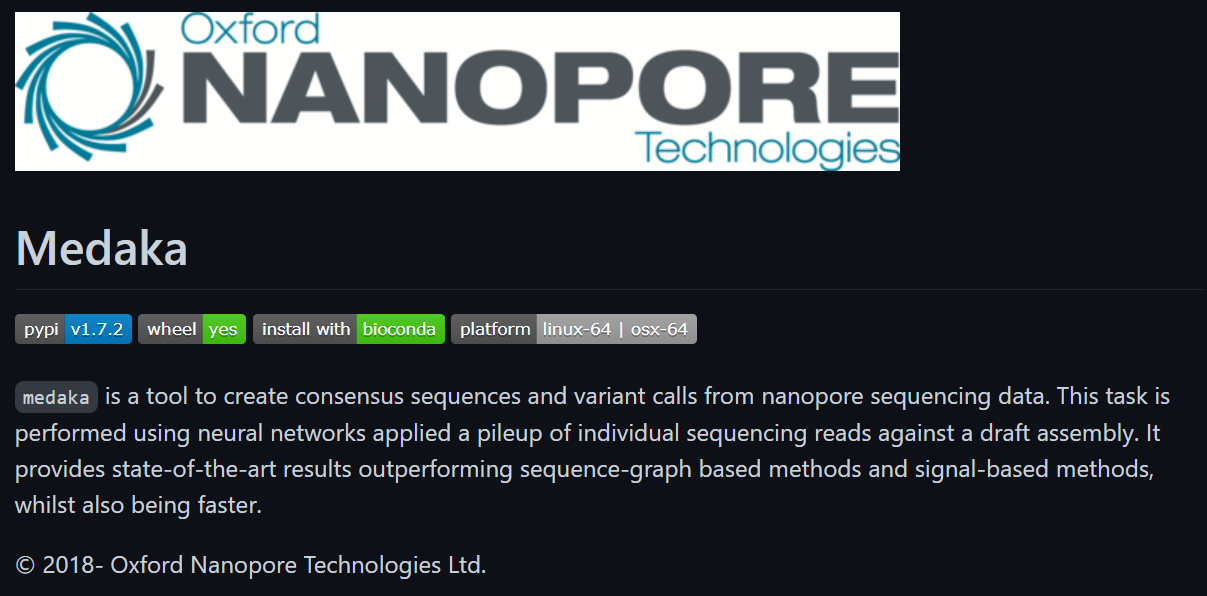

In [ ]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh                 #Descargamos el archivo para la instalación de conda
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh                                                  #Otorgamos la caracteristica ejecutable +x
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local                                #Ejecutamos el archivo para que ocurra la instalación # aprox 3 min

In [ ]:
#! wget https://github.com/Jpablo334/Workshop_virus/raw/master/06_barcode09_filt.fastq           #Archivo fastq
#! wget https://github.com/Jpablo334/Workshop_virus/raw/master/05_nCoV_2019.reference.fasta      #genoma de referencia

Google colab tiene algunos inconvenientes con la instalación de medaka directo desde conda, por lo que debemos crear un ambiente con mamba solo para usar medaka

In [ ]:
! conda install -y -c "conda-forge/label/cf202003" mamba
! mamba create -n medaka -y -c conda-forge -c bioconda medaka #5:30 min

**Medaka** requiere los datos ya obtenidos del basecalling y nos entrega como salida los archivos
Incluye a minimap v2.17. Es bastante rápido y si queremos ser aún más rápidos tiene la opción de ser ejecutado usando GPUs.

Es importante **seleccionar el modelo** de acuerdo al basecaller utilizado y la celda de flujo como input para la red neuronal.

**consensus.fasta** -> corresponde una secuencia concenso creada a aprtir del alineamiento

**consensus_probs.hdf**-> Este archivo no es útil para el usuario, contiene la salida de los calculos de la red neuronal  

**calls_to_draft.bam**-> contiene la información del alineamiento en formato binario

para más info https://github.com/nanoporetech/medaka

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
python --version
#Run Medaka # 35seg
medaka_consensus -i 06_barcode09_filt.fastq -d 05_nCoV_2019.reference.fasta -o medaka_results -m r103_hac_g507 # Obtener la secuencia concenso a partir de los reads guiado por el genoma de referencia 

Inspeccionar el alineamiento 

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
#Obtener estadisticas del alineamiento #1 seg
samtools coverage ./medaka_results/calls_to_draft.bam > barcode09_coverage.txt                               #Obtener numero de lecturas mapeadas

Haremos una evaluación de la profundidad y cobertura de la secuenciación respecto al genoma de referencia
http://www.htslib.org/doc/samtools-coverage.html

**Profundidad**: es la cantidad de veces que una base ha sido secuenciada. A mayor profundidad, más confianza en la identidad de la base secuenciada. En la imagen el genoma de referencia está en la parte de arriba. Abajo están los contigs secuenciados (serie de fragmentos de DNA que se solapan). Se representan 3 bases que varían en profunidad de lecturas. El primero tiene 5 lecturas, el segundo solo 1 y el tercero solo tres lecturas.

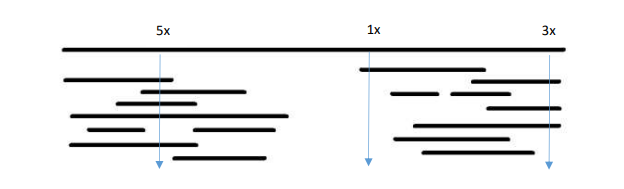

**Cobertura:** Es el porcentaje de todo el genoma que ha sido secuenciado. En el ejemplo de abajo, los contigs secuenciados cubren aproximadamente el 80% del genoma de referencia (en la parte superior de la imagen), lo cual significa que se ha secuenciado el 80% de las bases que conforman el genoma. No se puede identificar genes, SNP, etc en partes donde el genoma no tiene cobertura. 

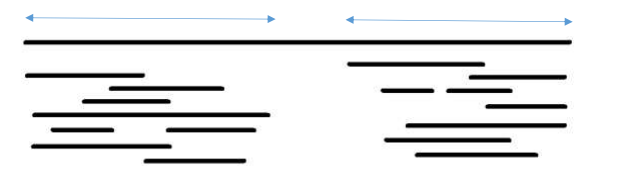

**Valores globales**

In [ ]:
import pandas as pd
coverage=pd.read_csv('barcode09_coverage.txt', sep='\t')
print(coverage)

**Valores zona específica** 

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
#Obtener estadisticas del alineamiento de regiones en particular de manera rapida
samtools coverage -A -w 60 -r MN908947.3:0K-30K ./medaka_results/calls_to_draft.bam       # genoma completo
samtools coverage -A -w 60 -r MN908947.3:21598-22478 ./medaka_results/calls_to_draft.bam  #spike 21.598-22.478
samtools coverage -A -w 60 -r MN908947.3:0-50 ./medaka_results/calls_to_draft.bam         #zona inicial del genoma
samtools coverage -A -w 60 -r MN908947.3:29000-30000 ./medaka_results/calls_to_draft.bam  #orf1a 249-13469
samtools coverage -A -w 60 -r MN908947.3:20k-20.2k ./medaka_results/calls_to_draft.bam  #orf1a 249-13469

# **Predicción de ORFs y anotación**

---



Obteniendo la secuencia concenso pasamos a la predicción de genes con PRODIGAL
https://www.biorxiv.org/content/10.1101/2021.12.11.472104v1

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente # 1 min
conda activate medaka

conda install -y -c bioconda prodigal 

**Prodigal** es un metodo de **predicción ab initio** (no es supervisado). Por lo tanto, no se basa en conocimiento previo para predecir **ORFs**, a diferencia de las herramientas basadas en homología de secuencia como BLAST. No requiere secuencias anotadas previamente para identificar genes potenciales dentro de un nuevo genoma. Sin embargo, para sobrellevar estas limitaciones se usa BLAST para identificar genes adicionales con alta identidad (homología) en el genoma de referencia de SARSCoV2. Por último, como alternativa se puede usar Prokka. 

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
#prodigal #1seg
prodigal -a barcode09.faa -d barcode09.fna -f gff -o barcode09.gff -i ./medaka_results/consensus.fasta

In [ ]:
! grep ">" barcode09.faa| wc -l                                                   #12 secuencias de proteinas predichas 
! grep ">" barcode09.fna| wc -l                                                   #12 secuencias de nt ORF
! grep "CDS"  barcode09.gff| wc -l                                                #12 características respresentadas en el gff

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell         
#Activar el ambiente
conda activate medaka
conda install -y -c bioconda blast             

**Descargar la base de datos de proteinas de swiss prot para microorganismos**

In [ ]:
! wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz # Descarga las secuencias de microorganismos swissprot

**Descromipimir el archivo descargado**

In [ ]:
! gunzip uniprot_sprot.fasta.gz #descomprime el archivo 


**Generamos una base de datos local**




In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
makeblastdb -in uniprot_sprot.fasta -dbtype prot                                                                   #Genera una base de datos local para realizar el blastp

**Realizamos un blastp contra la base de datos de microorganismos de swisprot**

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
blastp -num_threads 2 -db uniprot_sprot.fasta -num_descriptions 5 -num_alignments 2 -evalue 1e-5 -query barcode09.faa -out barcode09.bp # Ejecuta el blastp

Hasta aquí tenemos las proteinas que pueden provenir de las regiones reconocidas como probables ORF

**Alineamos las secuencias obtenidas para los genes predichos**

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
minimap2 # se instaló con medaka
minimap2 -ax map-ont -t 4 05_nCoV_2019.reference.fasta barcode09.fna  | samtools view -bS -F 4 - | samtools sort -o barcode09_ann.sorted.bam


In [ ]:
!samtools index barcode09_ann.sorted.bam

**Visualizar la localización de estas secuencias en el genoma con IGV**

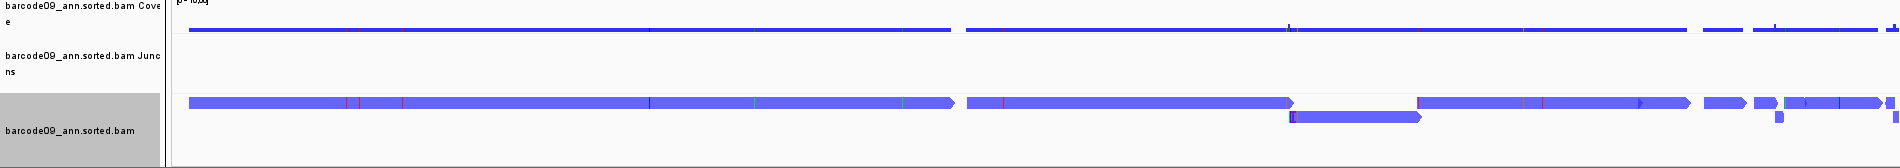

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
conda install -y -c "bioconda/label/cf201901" bedtools


In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka

bedtools bamtobed -i barcode09_ann.sorted.bam > barcode09_ann.sorted.bed              # Obtener un archivo bed a partir de alineamiento (bam) 

In [ ]:
! head -n 30 barcode09_ann.sorted.bed

**Descargar archivo de anotación, descomprimir y revisarlo**

In [ ]:
! wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.gff.gz

In [ ]:
! gunzip GCF_009858895.2_ASM985889v3_genomic.gff.gz

In [ ]:
! head -n 30 GCF_009858895.2_ASM985889v3_genomic.gff

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
conda install -y -c bioconda bedops # 1 min 20 sec

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
convert2bed -i gff < GCF_009858895.2_ASM985889v3_genomic.gff > sorted_sc2_gff.bed

In [ ]:
! head sorted_sc2_gff.bed

**Genoma y anotación de referencia NCBI SARSCoV2**

https://www.ncbi.nlm.nih.gov/projects/sviewer/?id=NC_045512&tracks=[key:sequence_track,name:Sequence,display_name:Sequence,id:STD649220238,annots:Sequence,ShowLabel:false,ColorGaps:false,shown:true,order:1][key:gene_model_track,name:Genes,display_name:Genes,id:STD3194982005,annots:Unnamed,Options:ShowAllButGenes,CDSProductFeats:true,NtRuler:true,AaRuler:true,HighlightMode:2,ShowLabel:true,shown:true,order:9]&v=1:29903&c=null&select=null&slim=0

# **Análisis de variantes**

---



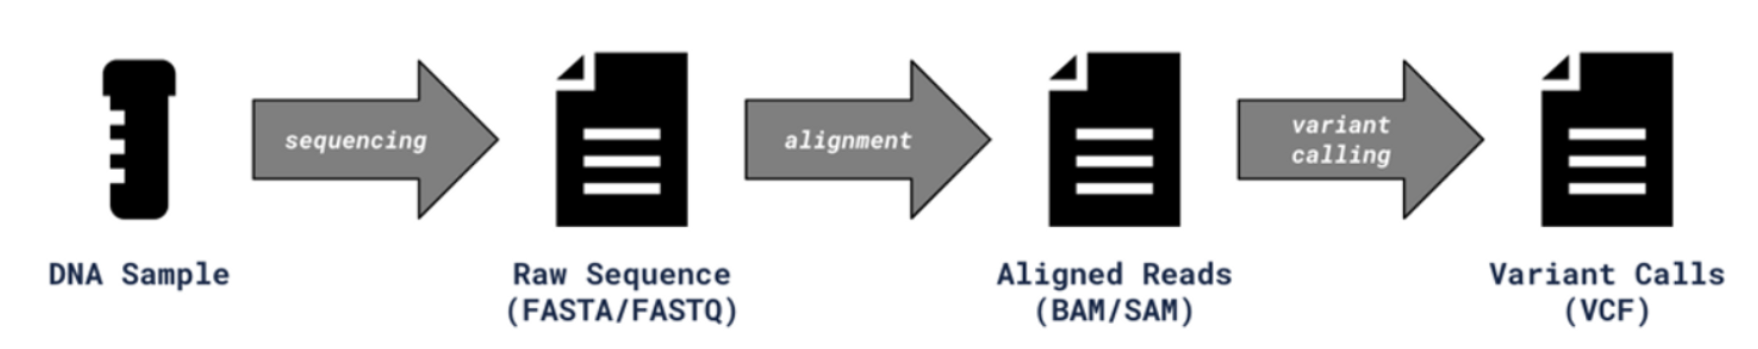

**VCF (Variant Calling File)** es un archivo que especifica variaciones en la secuencia de un gen en formato tabulado. El "llamado de variantes" realizado a partir de un alineamiento (BAM/SAM) identifica los cambios en un genoma en particular comparándolo con el genoma de referencia.

indica: fecha,programa usado para su obtención, referencia utilizada

*   CHROM: cromosoma
*   POS: posición en la referencia
*   ID: identificador unico
*   REF: bases en la referencia, las inserciones se identifican con un punto.
*   ALT: Base alternada, las deleciones se representan con un punto.
*   QUAL: score de calidad, 100 significa 1 en 10^10 de probabilidad de error. (entonces alta confianza)
*   FILTER: indica si fallo o pasó el filtro.



*  GT (Genotype) indicates which alleles separated by / (unphased) or | (phased).
*   GQ is Genotype Quality which is a single integer.

https://www.genomoncology.com/blog/what-is-a-variant-call-format-vcf-file


 



In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
#Activar el ambiente
conda activate medaka
medaka variant 05_nCoV_2019.reference.fasta ./medaka_results/consensus_probs.hdf ./medaka_results/barcode09.vcf

Medaka llama SNP/indel basado en aprendizaje profundo de datos de lecturas largas predice SNPs a partir de las lecturas sin fase antes de ponerlos en fase. Para cada conjunto de reads en fase, Medaka termina haciendo un llamado de SNP e indel. Genes 2022, 13(9), 1583; https://doi.org/10.3390/genes13091583

Mas info variant calling con medaka:
https://labs.epi2me.io/notebooks/Human_Variant_Calling_with_Medaka.html#:~:text=Medaka%27s%20workflow&text=Variant%20calling%20is%20a%20three,of%20SNP%20and%20INDEL%20variants.


Visualizar el archivo **barcode09.vcf**






In [ ]:
! head -n 30 ./medaka_results/barcode09.vcf

# **Anotar los cambios en los genes respectivos**

---



Descargue el archivo barcode09.vcf y súbalo a la siguiente página web

https://covid-19.ensembl.org/Tools/VEP

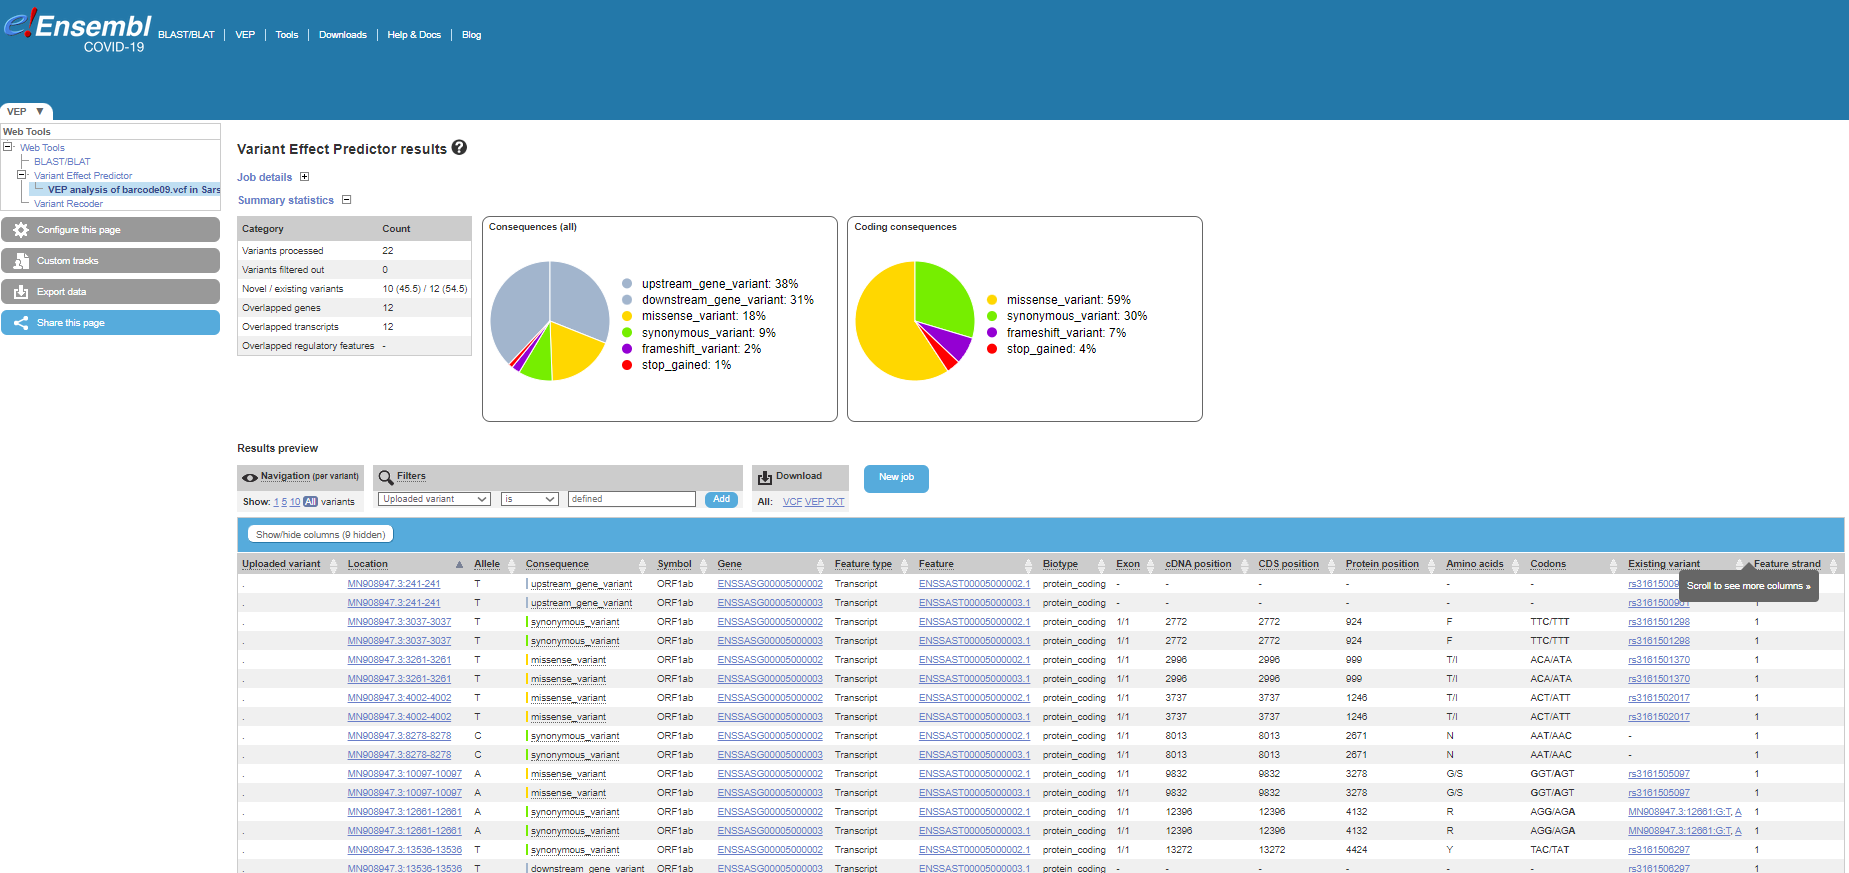

# **Descargar la secuencia consensus.fasta y subir en la página de Usher para ver filogenia y la variante más cercana**

---

Cargaremos el archivo **concensus.fasta** en la página de **UShER**: Ultrafast Sample placement on Existing tRee. 

* UShER es un programa para la colocación rápida y precisa de muestras en filogenias existentes.

https://genome.ucsc.edu/cgi-bin/hgPhyloPlace



---


Los términos mutación, variante y cepa son frecuentemente intercambiados para describir la epidemiología de SARS-CoV2 pero la distinción es importante. 

*  **Mutación**: se refiere al cambio en la secuencia: D614G.
*  **Variante**: Los genomas que difieren en secuencia 
*  **Cepa**: una variante que tiene un fenotipo diferente demostrable (ej. diferencia en la antigenicidad, transmisibilidad, o virulencia).

**Variante siendo monitorizadas (VBM)** : asociadas con enfermedad más severa o de mayor transmisión pero ya no se detectan o circulan en niveles muy bajos. Estas variantes no representan un riesgo significativo para la salud pública. En EEUU
* Alpha (B.1.1.7 and Q lineages)
* Beta (B.1.351 and descendent lineages)
* Gamma (P.1 and descendent lineages)
* Delta (B.1.617.2 and AY lineages)
* Epsilon (B.1.427 and B.1.429)
* Eta (B.1.525)
* Iota (B.1.526)
* Kappa (B.1.617.1)
* 1.617.3
* Mu (B.1.621, B.1.621.1)
* Zeta (P.2)

**Variante de interés (VOI)**: Una variante con marcadores genéticos específicos que se ha asociado con cambios en la unión al receptor, neutralización reducida por anticuerpos generados contra infecciones o vacunas previas, eficacia reducida de los tratamientos, impacto diagnóstico potencial o aumento previsto en la transmisibilidad o gravedad de la enfermedad.

Una variante de interés puede requerir una o más acciones de salud pública apropiadas, incluida la vigilancia secuencial mejorada, la caracterización de laboratorio mejorada o las investigaciones epidemiológicas para evaluar la facilidad con la que el virus se propaga a otras personas, la gravedad de la enfermedad, la eficacia de la terapia y si actualmente está aprobada o no. vacunas autorizadas ofrecen protección.

**Variante de preocupación (VOC)**:
Una variante para la que existe evidencia de un aumento en la transmisibilidad, enfermedad más grave (por ejemplo, aumento de hospitalizaciones o muertes), reducción significativa en la neutralización por anticuerpos generados durante una infección o vacunación previa, efectividad reducida de tratamientos o vacunas,
o fallas en la detección de diagnósticos.

https://www.cdc.gov/coronavirus/2019-ncov/variants/variant-classifications.html

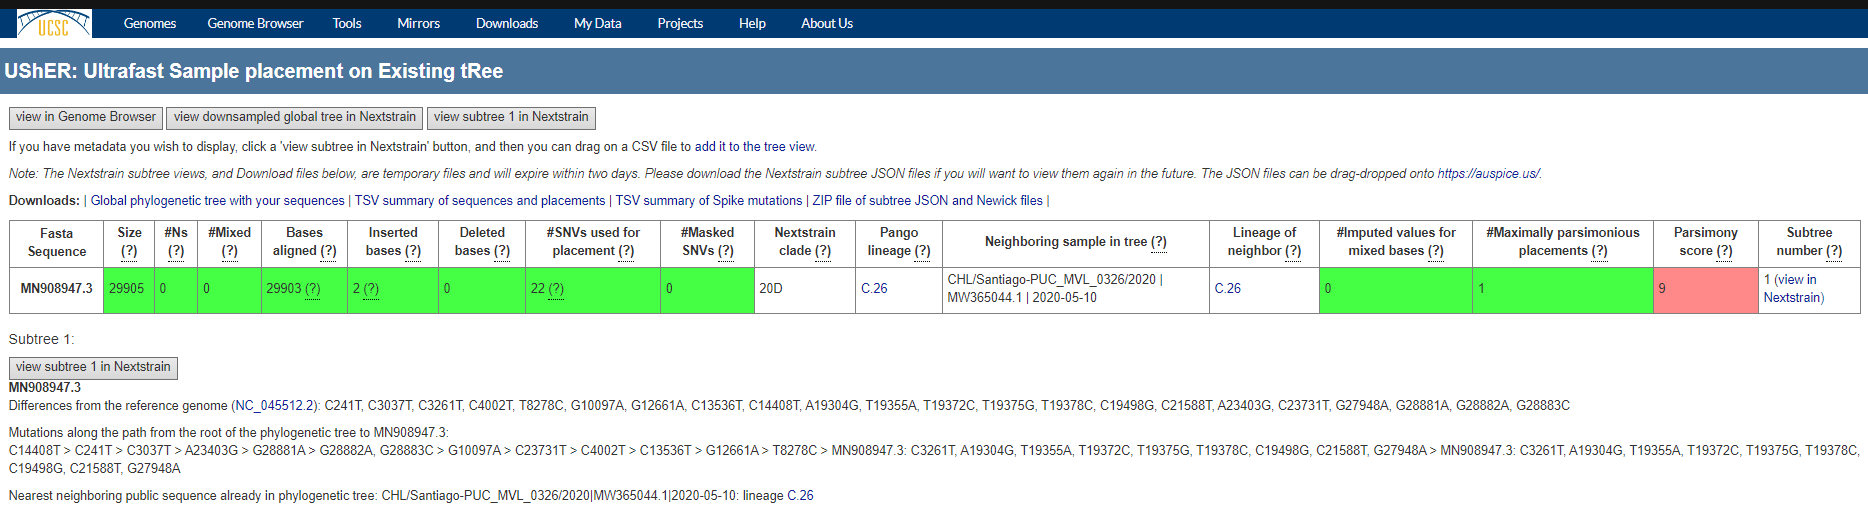

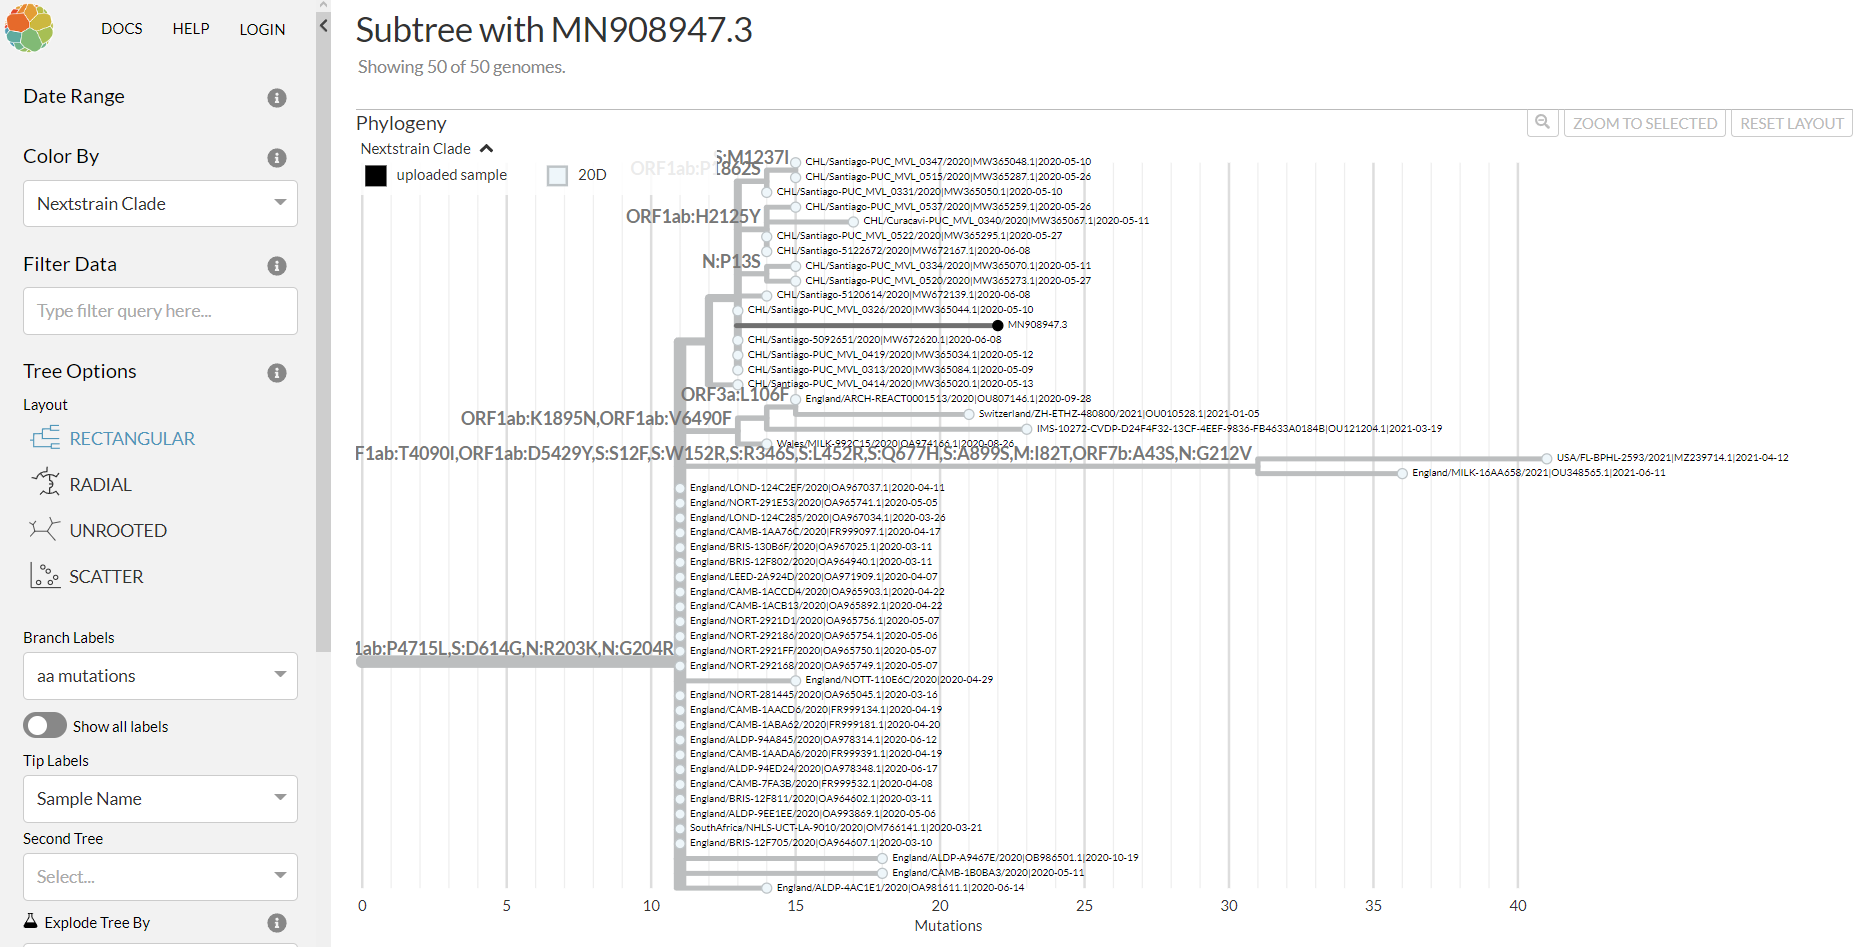


https://cov-lineages.org/lineage_list.html

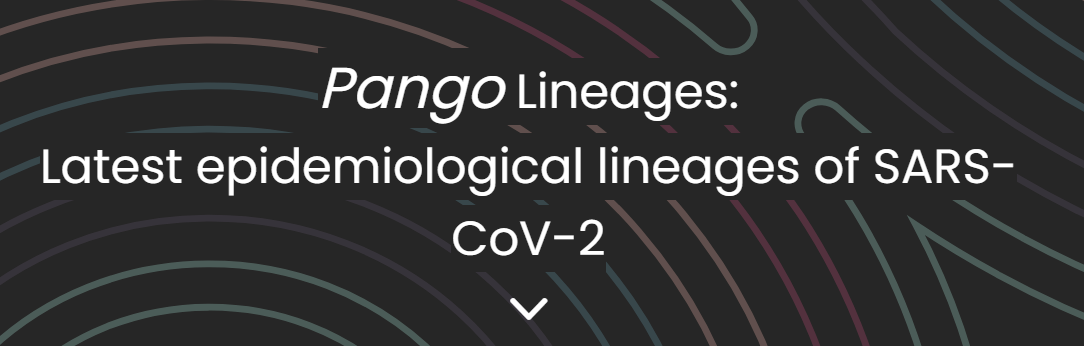 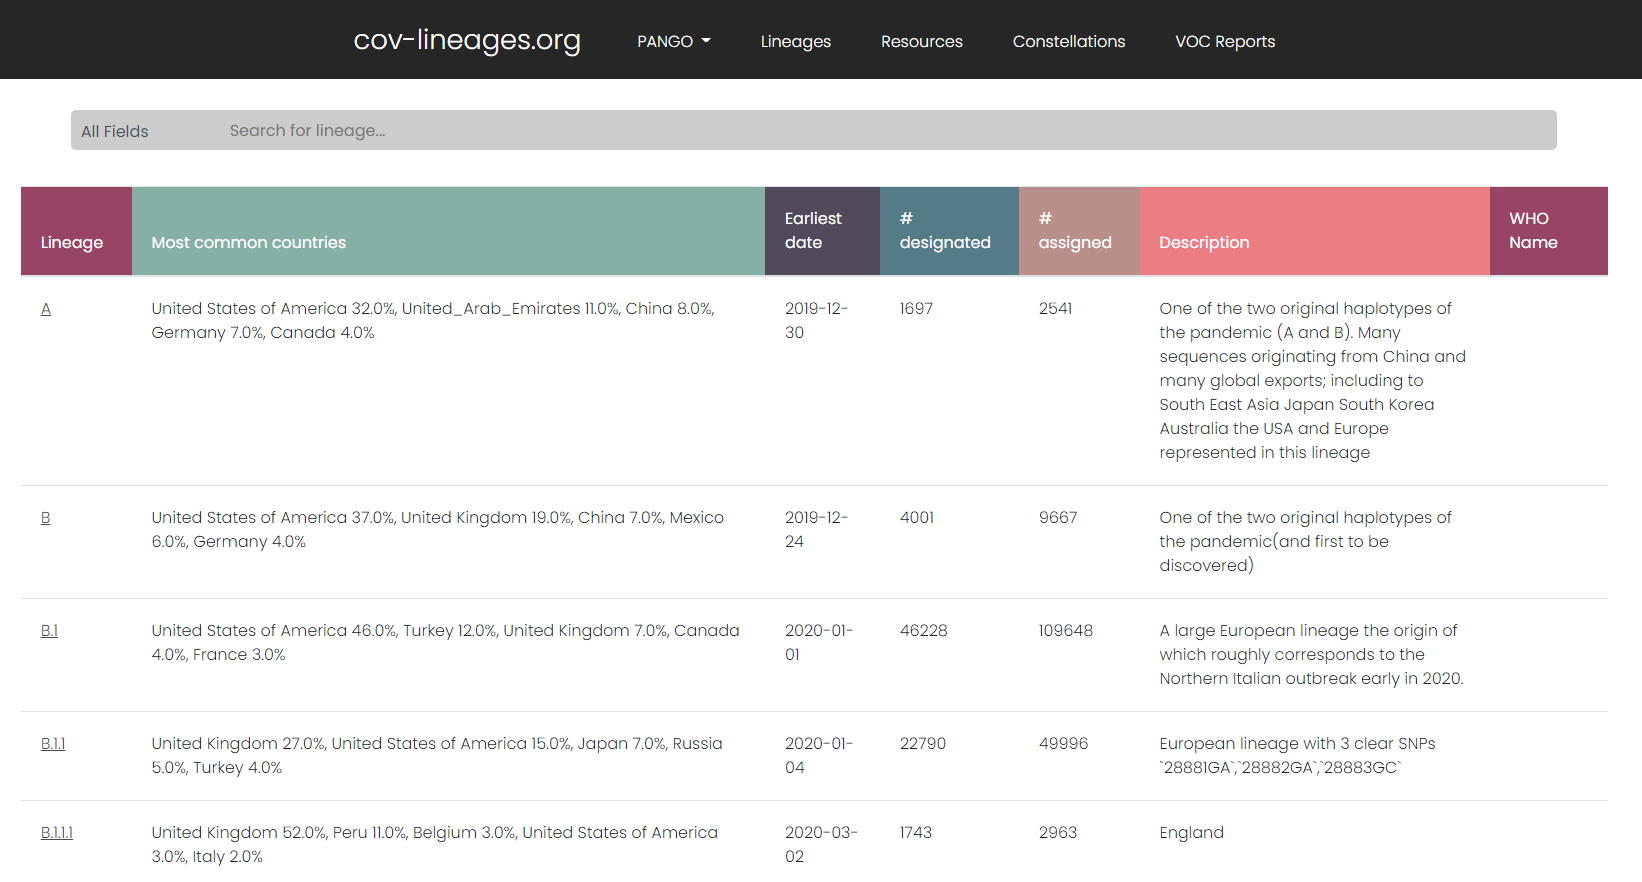

**Lo mismo, automático, pero ahora lo entendemos**

**GenomeDetective:**
https://www.genomedetective.com/app/typingtool/virus/

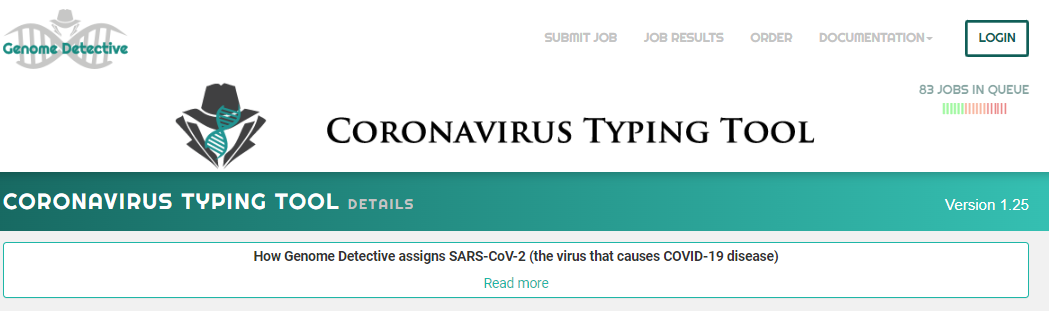